# Required MBTA zoning changes

Like most communities in MA with a housing shortage, Waltham has to change our zoning to allow a certain amount of density by-right in order
to comply with the MBTA Communities law.

This [page](https://www.mass.gov/info-details/compliance-model-components) has an Excel workbook that helps communities to pinpoint which restrictions
they might have in place that prevent MFH housing from being constructed around transit areas, as required by the law.

After the community is selected, a few housing required parameters will auto-populate (pre-calculated developable land amounts, required housing units etc.)
and the person filling out the workbook needs to define one or more districts that will be re-zoned to fulfill the requirement. The other sheets of the Excel
workbook allow entering restrictions like setbacks or floor area ratios and will flag requirements that need to be relaxed in order for the calculation to work.

In [25]:
import pandas as pd
import geopandas as geo_pd

from data.connect_db import get_db

from waltham.parcel import Parcel
from waltham.zone import Zone
from MBTA.MBTACalculator import MBTACalculator

con = get_db()

In [26]:
requirements = {
    "Community" : "Waltham",
    "Community category" : "Commuter Rail",
    "2020 Housing Units" : 26545,
    "Minimum multi-family unit capacity": 3982,
    "Minimum land area" : 50,
    "Developable station area" : 470,
    "% of district to be located in station area" : 50
}

### Where we can build

This is based on the parcels - we use the MBTA Communities compliance model's parcels for the defintion of buildable areas.

Let's assume that only parcels within the transit areas are selected for upzoning. There are some allowances I think for upzoning
elsewhere, but TOD makes the most sense so I hope we fully take advantage of it as much as possible.

In [27]:
# the basic shapefile is probably enough, but we'll go with the more complete 'detail' version
query = "select * from \"308_WALTHAM_detail\""

property_shapefiles_df = geo_pd.read_postgis(query, con)

# cleanup / removal of unneeded data
property_shapefiles_df.drop(axis="columns", labels=["Owner"], inplace=True)
property_shapefiles_df = property_shapefiles_df[["LOC_ID", "TRANSIT", "ACRES", "SQFT", "PublicInst", "NonPubExc", "Tot_Exclud", "Tot_Sensit", "geom"]]

# we're only considering TOD
property_shapefiles_df = property_shapefiles_df[property_shapefiles_df["TRANSIT"] == "Y"]

In [28]:
property_shapefiles_df.head()

,LOC_ID,TRANSIT,ACRES,SQFT,PublicInst,NonPubExc,Tot_Exclud,Tot_Sensit,geom
0,F_720576_2954833,Y,0.268435,11693.049406,11693.792788,2343.604743,11693.792788,0.000000,"MULTIPOLYGON (((219693.364 900605.105, 219632...."
2,F_722274_2954887,Y,0.552854,24082.340199,0.000000,906.091999,906.090355,2650.988149,"MULTIPOLYGON (((220183.593 900647.01, 220142.1..."
3,F_722477_2954895,Y,0.347326,15129.509686,0.000000,3468.070430,3468.070430,2245.188236,"MULTIPOLYGON (((220232.88 900672.543, 220232.5..."
4,F_722168_2954973,Y,0.278369,12125.747026,0.000000,0.000000,0.000000,0.000000,"MULTIPOLYGON (((220137.309 900682.421, 220131...."
5,F_720294_2955015,Y,0.334938,14589.901204,0.000000,12402.390239,12402.390239,11597.915270,"MULTIPOLYGON (((219577.102 900681.723, 219507...."


In [29]:
property_shapefiles_df.columns

Index(['LOC_ID', 'TRANSIT', 'ACRES', 'SQFT', 'PublicInst', 'NonPubExc',
       'Tot_Exclud', 'Tot_Sensit', 'geom'],
      dtype='object')

### What is curently built

This comes from the tax assessments data

In [30]:
query = "select * from \"M308Assess_CY22_FY23\""

assessments_df = pd.read_sql(query, con)
assessments_df = assessments_df[["LOC_ID", "LOT_SIZE", "USE_CODE", "SITE_ADDR", "ZONING", "YEAR_BUILT", "BLD_AREA", "UNITS"]]

In [31]:
assessments_df.columns

Index(['LOC_ID', 'LOT_SIZE', 'USE_CODE', 'SITE_ADDR', 'ZONING', 'YEAR_BUILT',
       'BLD_AREA', 'UNITS'],
      dtype='object')

In [32]:
property_shapefiles_df = property_shapefiles_df.merge(assessments_df, on="LOC_ID", how="inner")

# cleanup
property_shapefiles_df["USE_CODE"] = property_shapefiles_df["USE_CODE"].astype(int)

In [33]:
property_shapefiles_df.columns

Index(['LOC_ID', 'TRANSIT', 'ACRES', 'SQFT', 'PublicInst', 'NonPubExc',
       'Tot_Exclud', 'Tot_Sensit', 'geom', 'LOT_SIZE', 'USE_CODE', 'SITE_ADDR',
       'ZONING', 'YEAR_BUILT', 'BLD_AREA', 'UNITS'],
      dtype='object')

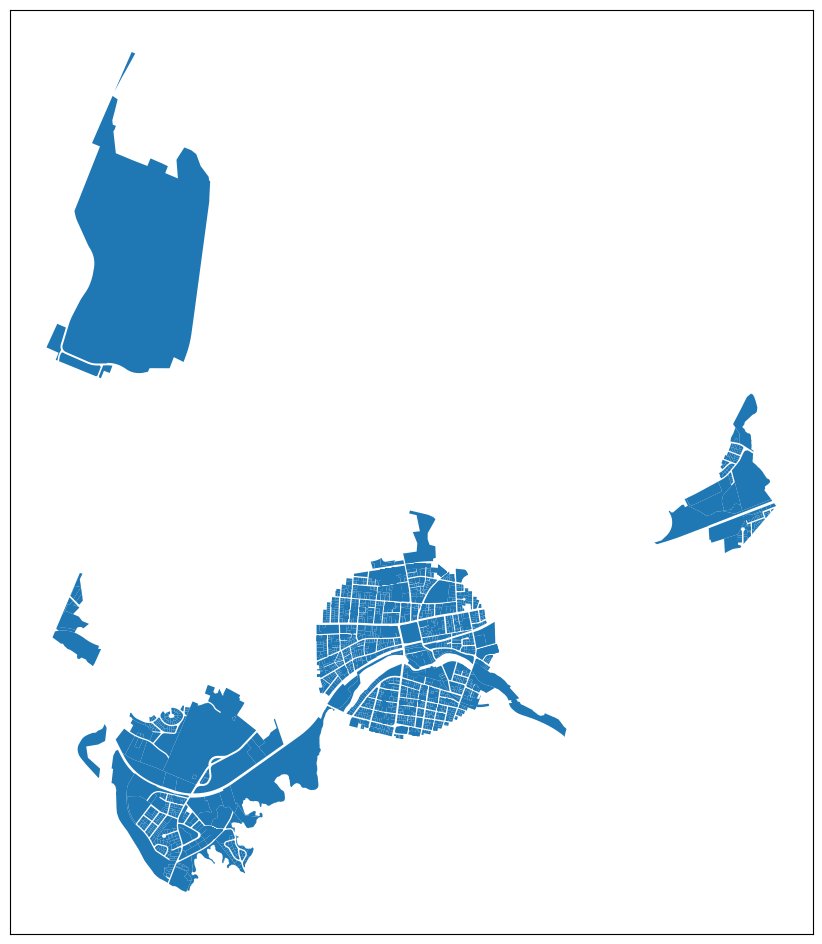

In [34]:
ax = property_shapefiles_df.plot(figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Upzoning scenarios

1. Current as-built situation
2. Current as-of-right situation
3. Current as-of-right + removal of parking minimums around transit

In [35]:
# as built - sum up all UNITS entries for USE_CODE < 200 (i.e. residential)
property_shapefiles_df[property_shapefiles_df["USE_CODE"] < 200]["UNITS"].sum()

np.int64(6610)

So 'as-built' we're actually fine, but the issue is they need to be 'as-of-right', so we don't lose the housing should something happen to the housing that's already in place.

For 'as-of-right' - we need to find the assigned zones for each parcel, then lookup the zoning rules for each parcel and determine what actually can get built.

In [36]:
zoning_rules_df = pd.read_csv("data/zoning_rules_table.csv")
zoning_rules_df.set_index("District", inplace=True)
zoning_rules_df.head()

,front setback,side setback,rear setback,height,stories,FAR by right,max lot coverage,min open space,lot area,max DUA,lot frontage
District,,,,,,,,,,,
RA1,40,20,40,35,2.5,NaN,0.20,NaN,20000.0,NaN,100
RA2,40,20,40,35,2.5,NaN,0.20,NaN,15000.0,NaN,80
RA3,25,15,30,35,2.5,NaN,0.25,NaN,9600.0,NaN,70
RA4,25,15,30,35,2.5,NaN,0.25,NaN,7000.0,NaN,60
RB,15,10,30,40,3.0,NaN,0.30,NaN,6000.0,NaN,60


In [37]:
query = "select * from \"WalthamZoning\""

zoning_df = geo_pd.read_postgis(query, con)

In [38]:
# assign existing parcels to zones
property_shapefiles_df["parcel_geometry"] = property_shapefiles_df["geom"]
property_shapefiles_df["geom"] = property_shapefiles_df.centroid
zoned_parcels_df = property_shapefiles_df.sjoin(zoning_df, how="left")
zoned_parcels_df.drop(axis="columns", labels=["index_right", "geom"], inplace=True)
zoned_parcels_df.rename(columns={"NAME": "ZONE", "parcel_geometry": "geom"}, inplace=True)

zoned_parcels_df = zoned_parcels_df[~zoned_parcels_df["ZONE"].isna()]

Look at all that beautiful nonsense:

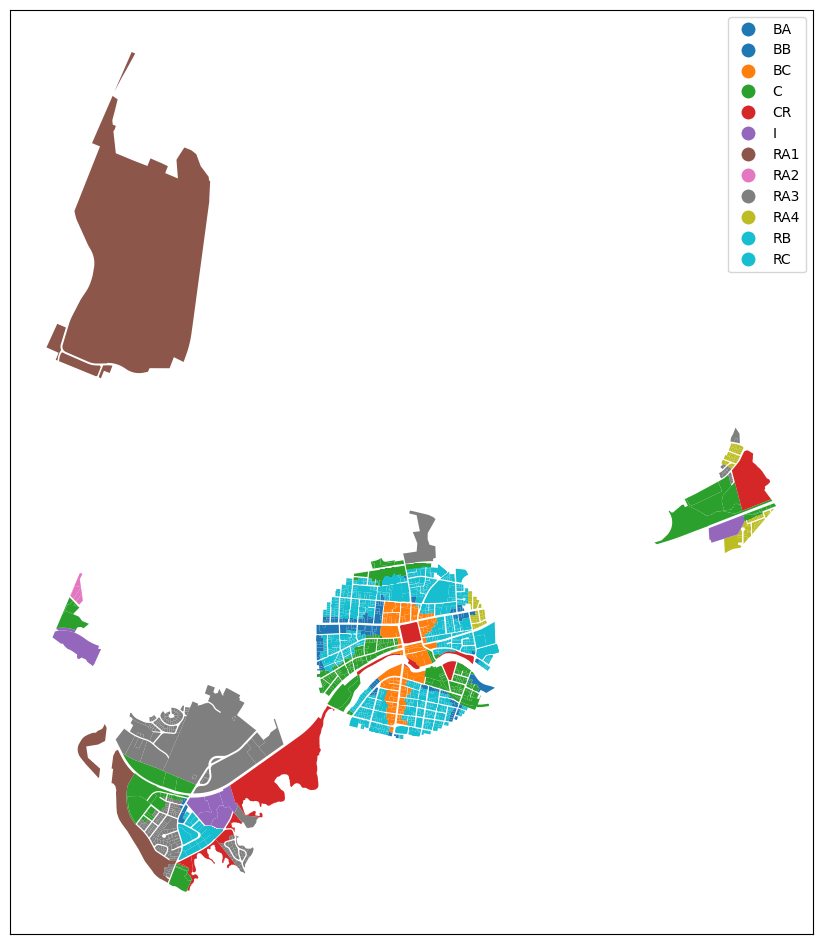

In [39]:
ax = zoned_parcels_df.plot(column="ZONE", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [40]:
def calculate_as_of_right_capacity(row, capacity_col, dua_col, parking_removed=False):

    parcel = Parcel(
        row["LOC_ID"],
        row["TRANSIT"],
        row["ACRES"],
        row["SQFT"],
        row["PublicInst"],
        row["NonPubExc"],
        row["Tot_Exclud"],
        row["Tot_Sensit"],
        row["ZONE"],
    )
    
    zoning_rules = zoning_rules_df.loc[parcel.zoning].to_dict()

    zone = Zone(
        name=row["ZONE"],
        front_setback=zoning_rules["front setback"],
        side_setback=zoning_rules["side setback"],
        rear_setback=zoning_rules["rear setback"],
        height=zoning_rules["height"],
        stories=zoning_rules["stories"],
        far=zoning_rules["FAR by right"],
        max_lot_coverage=zoning_rules["max lot coverage"],
        min_open_space=zoning_rules["min open space"],
        lot_area=zoning_rules["lot area"],
        max_dua=zoning_rules["max DUA"],
        lot_frontage=zoning_rules["lot frontage"]
    )

    calc = MBTACalculator(
        parcel,
        zone,
        parking_removed
    )

    return {capacity_col: calc.final_lot_mf_unit_capacity(), dua_col: calc.du_per_ac()}

capacity_col = "AS_OF_RIGHT_CAPACITY"
dua_col = "AS_OF_RIGHT_DUA"
zoned_parcels_df[[capacity_col, dua_col]] = zoned_parcels_df.apply(
    lambda row: calculate_as_of_right_capacity(row, capacity_col, dua_col), axis='columns', result_type='expand'
)

In [41]:
# as of right - this time we can count all parcels
zoned_parcels_df["AS_OF_RIGHT_CAPACITY"].sum()

np.float64(14538.0)

In [42]:
zoned_parcels_df["USE_CODE"]

0       903
1       101
2       101
3       101
4       101
       ... 
2690    101
2691    104
2692    325
2693    337
2694     14
Name: USE_CODE, Length: 2692, dtype: int64

So that actually seems like really good news... but let's see if we have higher capacity everywhere

In [43]:
def as_built_dua(row):
    if row["USE_CODE"] >= 200:
        return 0
    
    return row["UNITS"] / row["ACRES"]

zoned_parcels_df["AS_BUILT_DUA"] = zoned_parcels_df.apply(lambda row: as_built_dua(row), axis="columns")

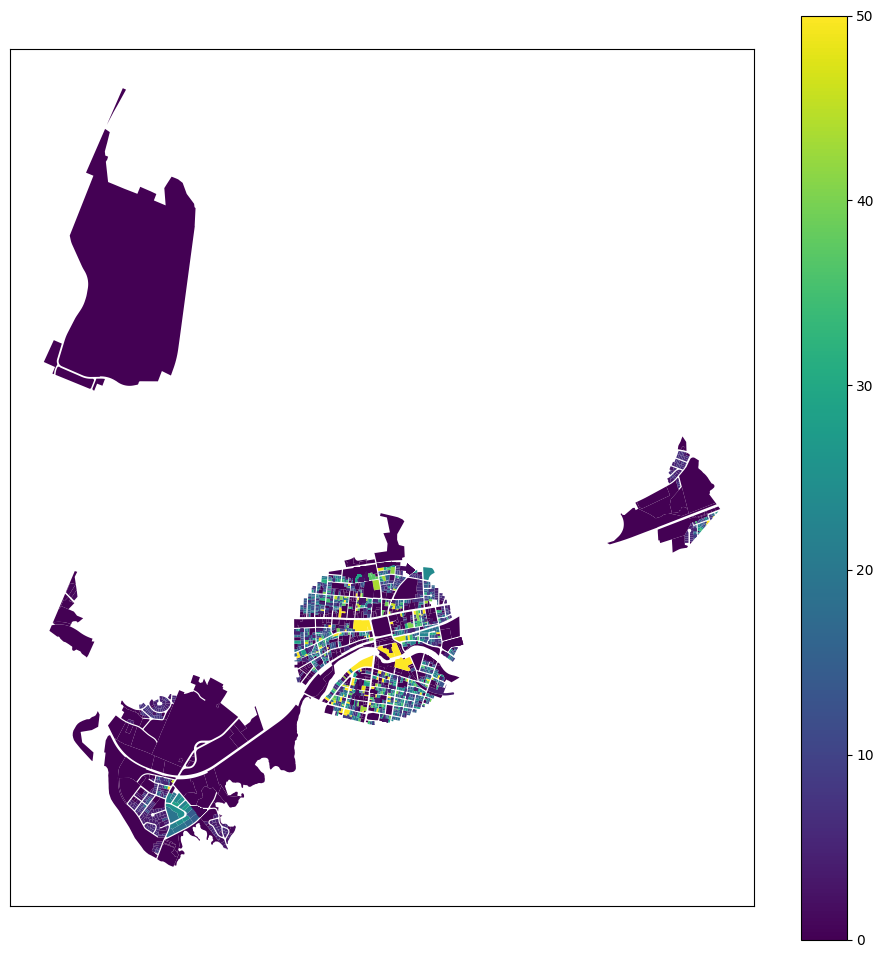

In [44]:
ax = zoned_parcels_df.plot(column="AS_BUILT_DUA", legend=True, figsize=(12, 12), vmax=50)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

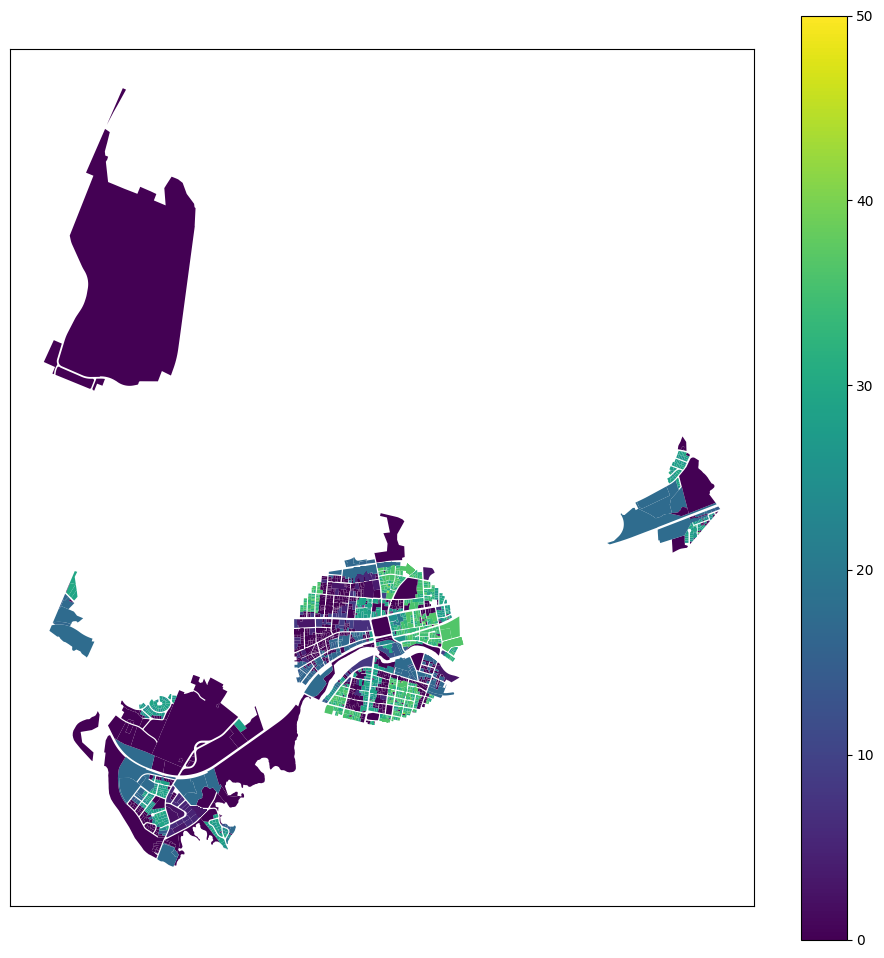

In [45]:
ax = zoned_parcels_df.plot(column="AS_OF_RIGHT_DUA", legend=True, figsize=(12, 12), vmax=50)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Looks like we get good upzoning growth in ward 8 but quite a few existing buildings would be lost if we had to build as-of-right.

What's not captured in the MBTA units calculator are the actual building geometry rules, which make this much harder.

### With parking requirements removed

In [46]:
capacity_col = "NO_PARKING_CAPACITY"
dua_col = "NO_PARKING_DUA"
zoned_parcels_df[[capacity_col, dua_col]] = zoned_parcels_df.apply(
    lambda row: calculate_as_of_right_capacity(row, capacity_col, dua_col, True), axis='columns', result_type='expand'
)

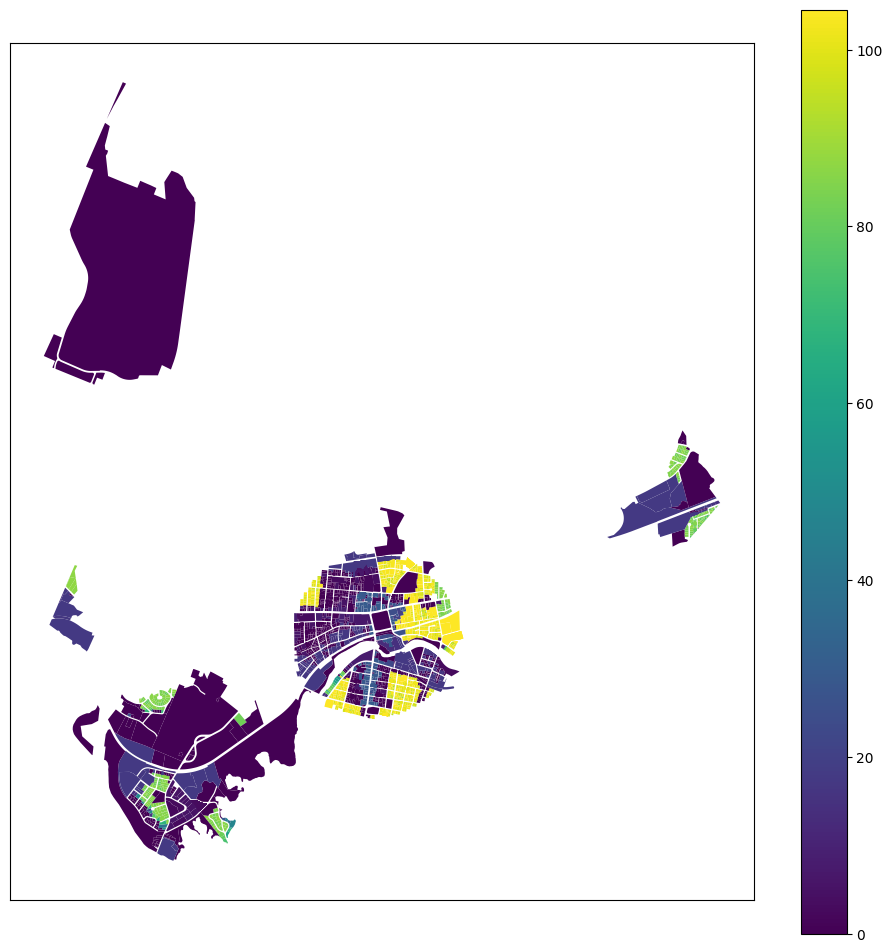

In [47]:
ax = zoned_parcels_df.plot(column="NO_PARKING_DUA", legend=True, figsize=(12, 12))

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

### Result
Basically we get 2x as many units when parking requirements are removed. And that's the only change on top of the by-right zoning change we've made.

In [48]:
zoned_parcels_df["NO_PARKING_CAPACITY"].sum()

np.float64(28649.0)